In [31]:
!pip install tensorflow keras

In [32]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,RMSprop
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import regularizers

In [33]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [34]:
path_No = 'C:\\Users\\dell\\Desktop\\archive\\no\\'
path_Yes = 'C:\\Users\\dell\\Desktop\\archive\\yes\\'

tumor = []
no_tumor = []

try:
    # Load 'yes' images
    for file in glob.iglob(path_Yes + '*'):
        img = cv2.imread(file)      # Reading the images from the path
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        # Changing the color from BGR to RGB
            img = cv2.resize(img, (128, 128)) 
            tumor.append((img, 1))  # Appending tuple with image and label 1 (indicating presence of tumor)
        else:
            print("Failed to read image:", file)

    # Load 'no' images
    for file in glob.iglob(path_No + '*'):
        img = cv2.imread(file)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))
            no_tumor.append((img, 0))  # Appending tuple with image and label 0 (indicating absence of tumor)
        else:
            print("Failed to read image:", file)

    # Concatenating the two lists and shuffle the data
    all_data = tumor + no_tumor

    # Splitting data and labels
    data = np.array([item[0] for item in all_data])
    labels = np.array([item[1] for item in all_data])

    # Print shapes of data and labels
    print("Data shape:", data.shape)
    print("Labels shape:", labels.shape)

except Exception as e:
    print("An error occurred:", e)


Failed to read image: C:\Users\dell\Desktop\archive\no\server.py.ipynb
Data shape: (254, 128, 128, 3)
Labels shape: (254,)


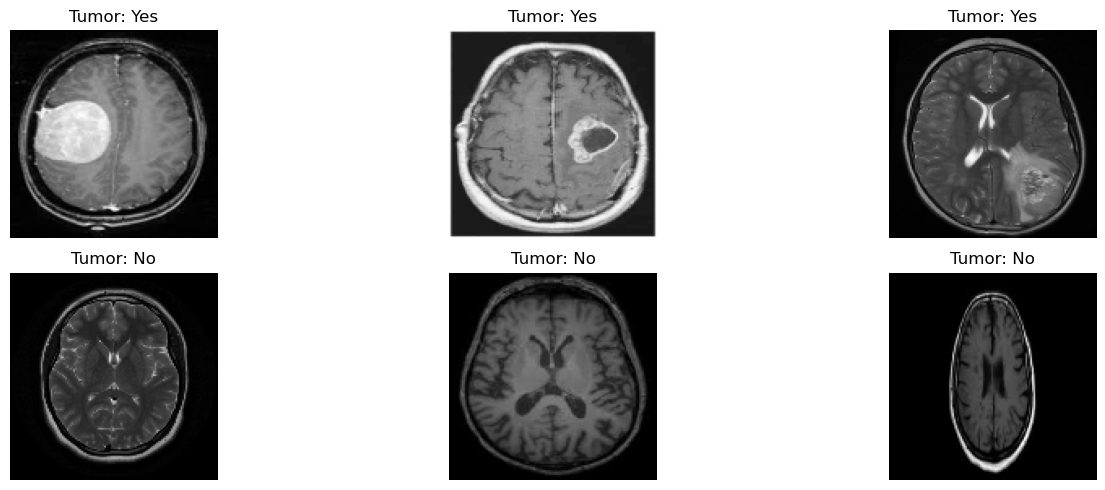

In [41]:
plt.figure(figsize=(15, 5))

# Display tumor images with label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(tumor[i][0])  
    plt.title("Tumor: Yes")  
    plt.axis('off')

# Display no_tumor images with label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(no_tumor[i][0])  
    plt.title("Tumor: No")  
    plt.axis('off')

plt.tight_layout()
plt.show()

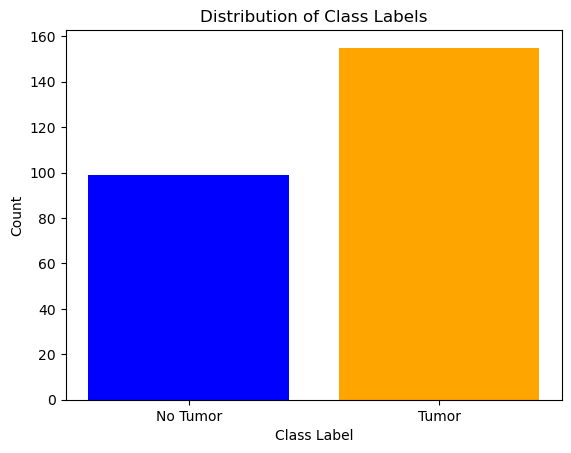

In [36]:
# Counting the occurrences of each class label
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

In [37]:
def crop_brain_region(image, size):
    
    # Converting the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Applying Gaussian blur to smooth the image and reduce noise
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Thresholding the image to create a binary mask
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    
    # Performing morphological operations to remove noise
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # Finding contours in the binary mask
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assuming the brain part of the image has the largest contour
    c = max(contours, key=cv2.contourArea)
    
    # Getting the bounding rectangle of the brain part
    x, y, w, h = cv2.boundingRect(c)
    
    # Drawing contours on the original image
    contour_image = cv2.drawContours(image.copy(), [c], -1, (0, 255, 0), 2)
    
    # Drawing bounding box on the original image
    bounding_box_image = cv2.rectangle(image.copy(), (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Cropping the image around the bounding rectangle
    cropped_image = image[y:y+h, x:x+w]
    
    # Resizing cropped image to the needed size
    resized_image = cv2.resize(cropped_image, size)
    
    return contour_image, bounding_box_image, cropped_image, resized_image

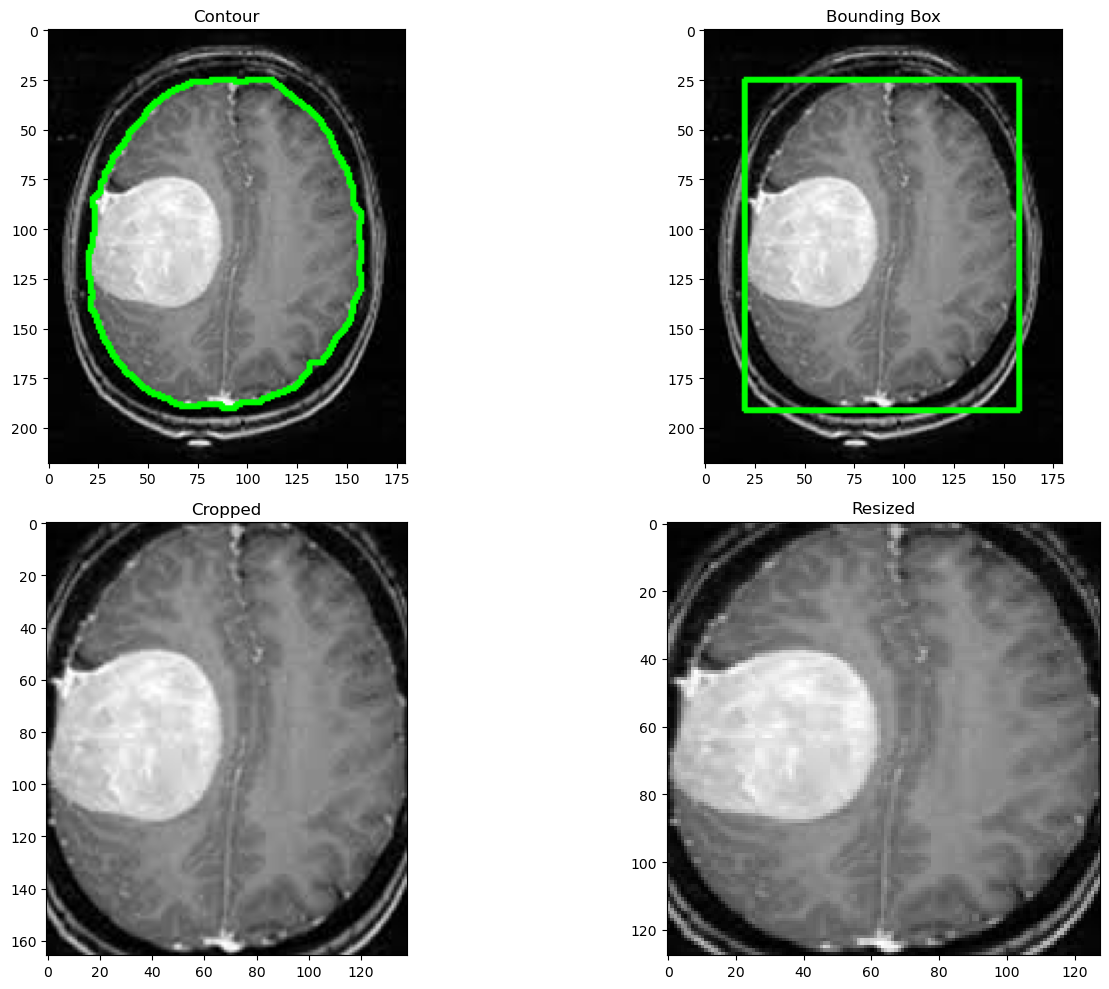

In [38]:
output_size = (128, 128)

example_image = cv2.imread('C:\\Users\\dell\\Desktop\\archive\\yes\\Y1.jpg')
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

contour_image, bounding_box_image, cropped_image, resized_image = crop_brain_region(example_image, output_size)


plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(contour_image)
plt.title("Contour")

plt.subplot(2, 2, 2)
plt.imshow(bounding_box_image)
plt.title("Bounding Box")

plt.subplot(2, 2, 3)
plt.imshow(cropped_image)
plt.title("Cropped")

plt.subplot(2, 2, 4)
plt.imshow(resized_image)
plt.title("Resized")

plt.tight_layout()
plt.show()

all_cropped = []

# Applying the crop function to each one of our images
for image in data:
    _, _, _, resized_image = crop_brain_region(image, output_size)
    all_cropped.append(resized_image)

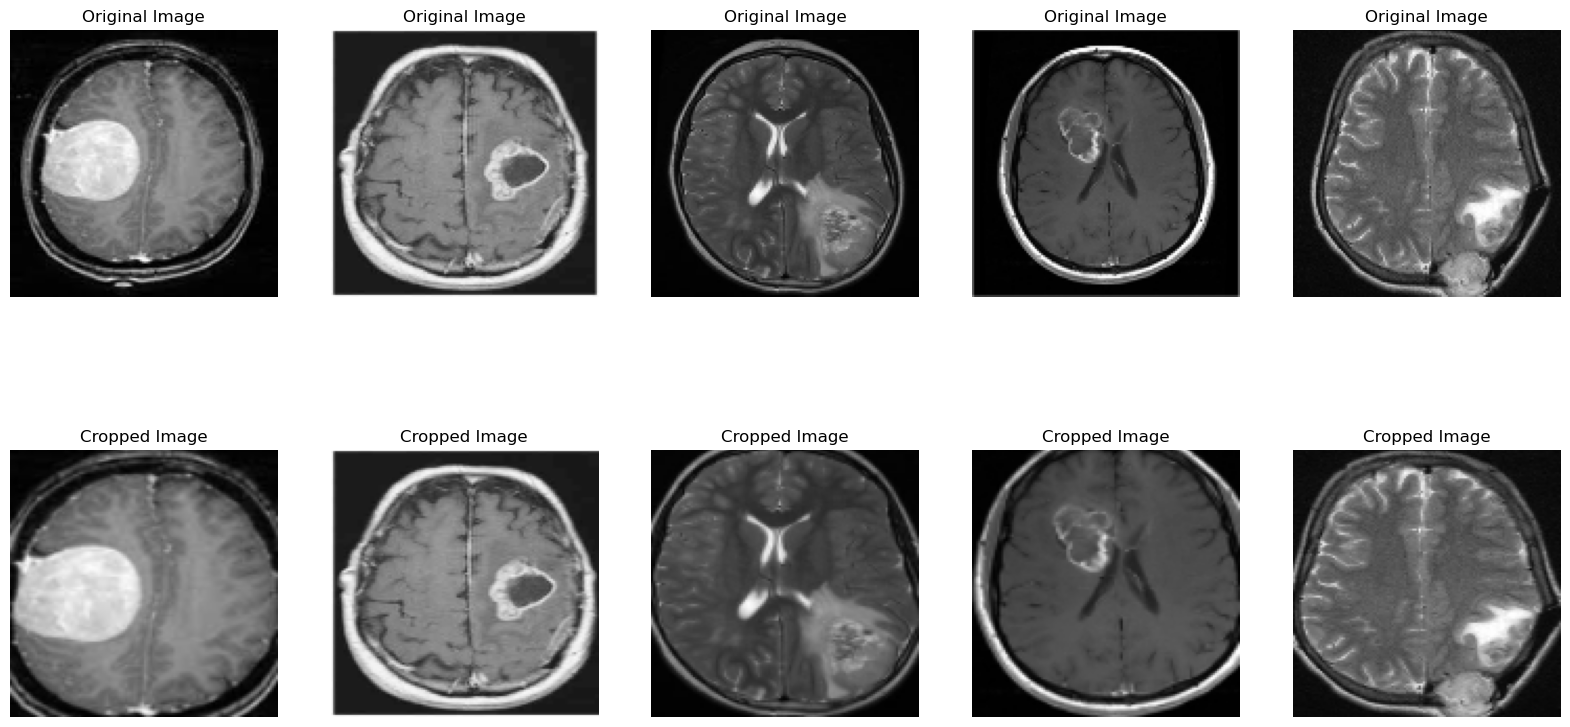

In [40]:
num_images_per_class = 5

class_0_counter = 0
class_1_counter = 0

plt.figure(figsize=(20, 10))

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, i + 1)
    plt.imshow(data[i])
    plt.title("Original Image")
    plt.axis("off")

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, num_images_per_class + i + 1)
    plt.imshow(all_cropped[i])
    plt.title("Cropped Image")
    plt.axis("off")

plt.show()

In [10]:
all_cropped=np.array(all_cropped)

In [11]:
# Shuffling the data to make sure the images are randomized and there is no order in labels
all_cropped_shuffled, labels_shuffled = shuffle(all_cropped, labels, random_state=42)

train_images, test_images, train_labels, test_labels = train_test_split(all_cropped_shuffled, labels_shuffled, test_size=0.2, random_state=42)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

print("Train data shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation data shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Test data shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train data shape: (203, 128, 128, 3)
Train labels shape: (203,)
Validation data shape: (26, 128, 128, 3)
Validation labels shape: (26,)
Test data shape: (25, 128, 128, 3)
Test labels shape: (25,)


In [12]:
print(np.max(train_images))
print(np.min(train_images))

255
0


In [13]:
train_images=train_images/255
test_images=test_images/255
val_images=val_images/255

In [14]:
print(np.max(train_images))
print(np.min(train_images))

1.0
0.0


In [15]:
from keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-4))
print(model.summary())


C:\Users\dell\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

None


In [16]:
epochs = 50 
batch_size = 32 

early_stopping = EarlyStopping(patience=5, monitor='val_loss')  # Defining early stopping to stop the model from overfitting


history = model.fit(train_images, 
                    train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(val_images, val_labels),
                   callbacks=[early_stopping])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 403ms/step - accuracy: 0.5669 - loss: 0.6853 - val_accuracy: 0.6154 - val_loss: 0.6559
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step - accuracy: 0.5670 - loss: 0.6735 - val_accuracy: 0.6154 - val_loss: 0.6562
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step - accuracy: 0.5670 - loss: 0.6762 - val_accuracy: 0.6154 - val_loss: 0.6519
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - accuracy: 0.5670 - loss: 0.6566 - val_accuracy: 0.6154 - val_loss: 0.6499
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 348ms/step - accuracy: 0.5682 - loss: 0.6516 - val_accuracy: 0.6154 - val_loss: 0.6456
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - accuracy: 0.5910 - loss: 0.6488 - val_accuracy: 0.6154 - val_loss: 0.6401
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - accuracy: 0.5938 - loss: 0.6172 - val_accuracy: 0.6154 - val_loss: 0.6346
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - accuracy: 0.6408 - loss: 0.6171 - val_accuracy: 0.6154 - val_loss:

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

predictions = model.predict(val_images)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(val_labels, binary_predictions)

accuracy = accuracy_score(val_labels, binary_predictions)
print("Accuracy on Validation Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
Accuracy on Test Set: 0.720 %


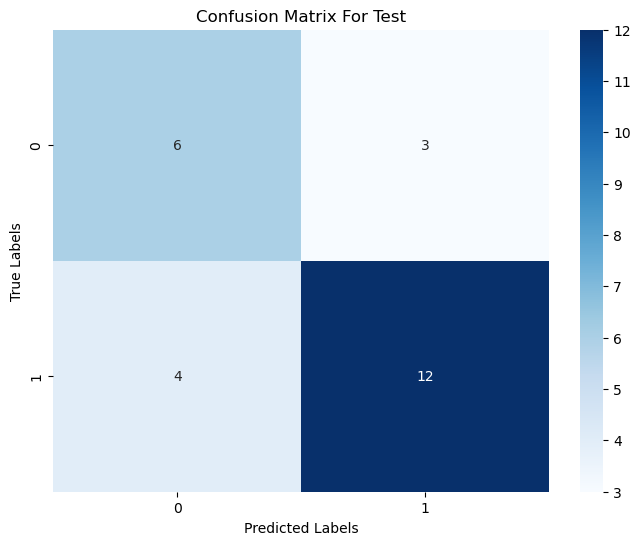

In [18]:
predictions = model.predict(test_images)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(test_labels, binary_predictions)

accuracy = accuracy_score(test_labels, binary_predictions)
print("Accuracy on Test Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

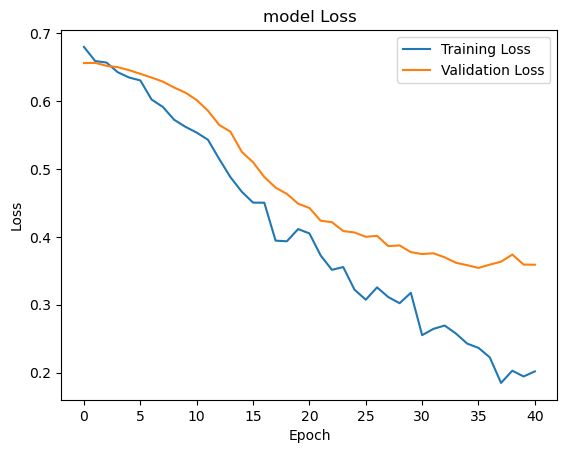

In [19]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

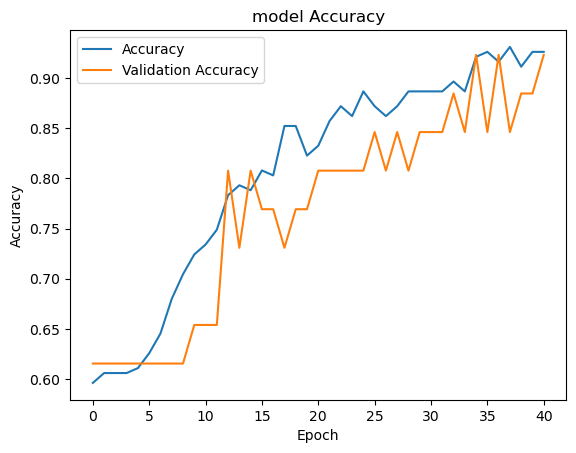

In [20]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,              # Rotation aléatoire de 0 à 20 degrés
    horizontal_flip=True,           # Retournement horizontal aléatoire
    vertical_flip=True,             # Retournement vertical aléatoire
    width_shift_range=0.1,          # Décalage aléatoire de la largeur jusqu'à 10%
    height_shift_range=0.1,         # Décalage aléatoire de la hauteur jusqu'à 10%
    shear_range=0.1,                # Intensité de cisaillement de 0.1 radians
    zoom_range=0.1,                 # Zoom aléatoire jusqu'à 10%
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    train_images, train_labels,
    batch_size=32
)

val_generator = val_datagen.flow(
    val_images, val_labels,
    batch_size=32
)


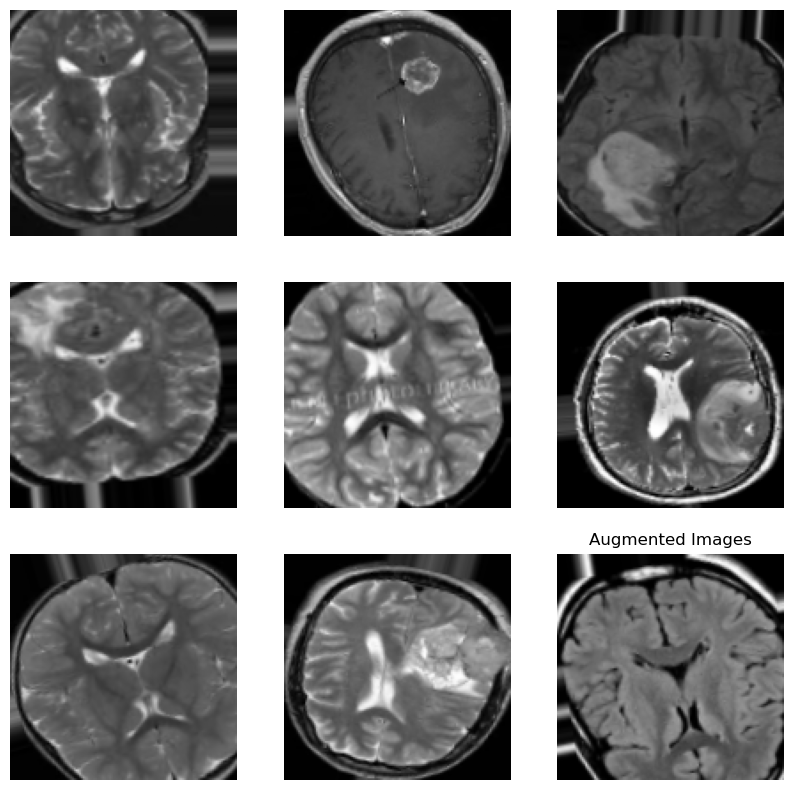

In [22]:
augmented_images, _ = next(train_datagen.flow(train_images, train_labels, batch_size=32))

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.title("Augmented Images")
plt.show()


In [28]:
# Importer le modèle VGG16 et d'autres couches et fonctions nécessaires
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Charger le modèle VGG16 pré-entraîné sans la couche Dense supérieure, en spécifiant la forme d'entrée
base_model = VGG16(weights='/kaggle/input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                   include_top=False, input_shape=(128, 128, 3))

# Geler les poids des couches du modèle de base pour empêcher leur mise à jour pendant l'entraînement
base_model.layers[0].trainable = False

# Ajouter une couche de Global Average Pooling pour réduire les dimensions de sortie
x = GlobalAveragePooling2D()(base_model.output)

# Ajouter une couche Dense avec 128 neurones et une fonction d'activation 'relu', avec une régularisation L2
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)

# Ajouter une couche de Dropout pour régulariser le modèle et prévenir le surapprentissage
x = Dropout(0.5)(x)

# Ajouter la couche de sortie avec une seule unité et une fonction d'activation 'sigmoid' pour la classification binaire
predictions = Dense(1, activation='sigmoid')(x)

# Créer le modèle final en spécifiant les entrées et les sorties
model = Model(inputs=base_model.input, outputs=predictions)

# Compiler le modèle en spécifiant la fonction de perte, l'optimiseur et les métriques à surveiller
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])


ValueError: The `weights` argument should be either `None` (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.  Received: weights=/kaggle/input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Définition du callback pour réduire le taux d'apprentissage lorsque la perte de validation cesse de s'améliorer après un certain nombre d'époques (patience).
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)

# Entraînement du modèle sur les données d'entraînement et de validation pour un nombre d'époques donné, avec les callbacks spécifiés pour surveiller et ajuster l'entraînement.
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/200


C:\Users\dell\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 629ms/step - accuracy: 0.6376 - loss: 0.9111 - val_accuracy: 0.8462 - val_loss: 0.5013 - learning_rate: 1.0000e-04
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 370ms/step - accuracy: 0.6652 - loss: 0.6867 - val_accuracy: 0.7692 - val_loss: 0.4151 - learning_rate: 1.0000e-04
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 356ms/step - accuracy: 0.6881 - loss: 0.5909 - val_accuracy: 0.8077 - val_loss: 0.5015 - learning_rate: 1.0000e-04
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 352ms/step - accuracy: 0.7008 - loss: 0.5881 - val_accuracy: 0.8462 - val_loss: 0.4941 - learning_rate: 1.0000e-04
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 392ms/step - accuracy: 0.6922 - loss: 0.5685 - val_accuracy: 0.8077 - val_loss: 0.4586 - learning_rate: 1.0000e-04
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 450ms/step - accuracy: 0.6490 - loss: 0.6230 - val_accuracy: 0.8846 - val_loss: 0.4529 - learning_rate: 1.0000e-04
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 403ms/step - accuracy: 0.7383 - loss: 0.53

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Accuracy on Validation Set: 0.846154


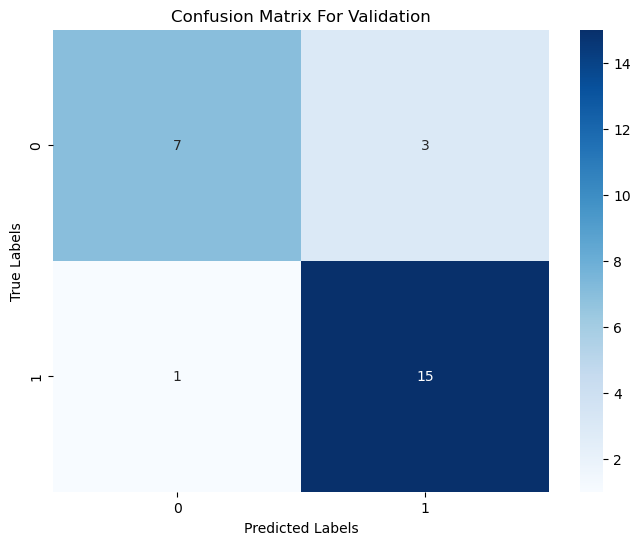

In [30]:
predictions = model.predict(val_images)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(val_labels, binary_predictions)

accuracy = accuracy_score(val_labels, binary_predictions)
print("Accuracy on Validation Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Accuracy on Test Set: 0.760000


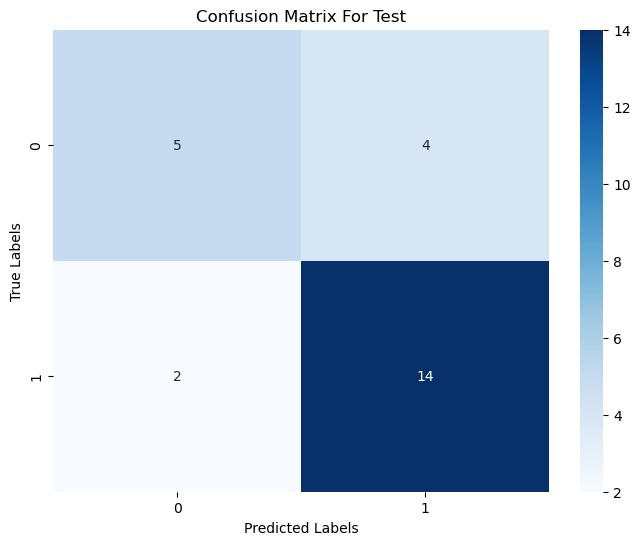

In [42]:
predictions = model.predict(test_images)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(test_labels, binary_predictions)

accuracy = accuracy_score(test_labels, binary_predictions)
print("Accuracy on Test Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

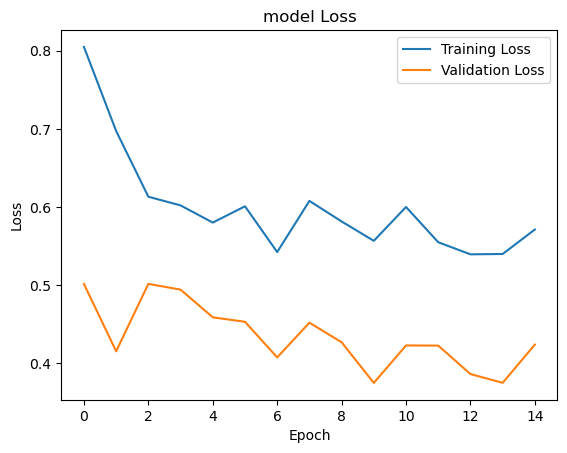

In [43]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

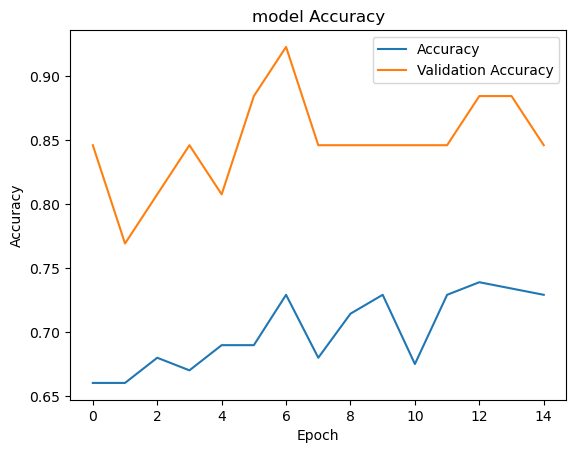

In [44]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
import os
from tensorflow.keras.models import save_model

model = model

# Define the path where you want to save the model
save_path = os.path.join(r'C:\Users\dell\Desktop\ML', 'model.h5')  

# Save the model to the specified path
save_model(model, save_path)

